<a href="https://colab.research.google.com/github/ramonVDAKKER/teaching-data-science-emas/blob/main/notebooks/emas_case1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Case 1

You only need to run the following code once per session. After this restart the kernel (Runtime>Restart runtime).

In [ ]:
%%capture
!git clone https://github.com/ramonVDAKKER/teaching-data-science-emas
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!jupyter nbextension enable --py widgetsnbextension

## 0. Imports

In [ ]:
import os
os.chdir("teaching-data-science-emas/notebooks")

Important packages for Python are <a href="http://www.numpy.org/">numpy</a> (for arrays, linear algebra, pseudorandom numbers etc.), <a href="http://pandas.pydata.org/">pandas</a> (contains convenient data structure called "pandas dataframe"), <a href="http://matplotlib.org/">matplotlib</a> & <a href="http://seaborn.pydata.org/"> seaborn</a> (for data visualisation), <a href="http://scikit-learn.org/stable/">sklearn</a> (scikit-learn; powerful package containing machine & statistical learning functions), and  <a href="https://www.statsmodels.org/stable/index.html">statsmodels</a> for statistical models and routines.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix,  accuracy_score, roc_auc_score, precision_recall_curve, RocCurveDisplay
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import xgboost as xgb

In [ ]:
%matplotlib inline

## 1. Load dataset & Elementary Data Analysis

### 1.1 Load and inspect data

Load dataset into a pandas dataframe:

In [ ]:
dataset = pd.read_csv("./data/case_1/DataTrain.csv")

We split the first dataset into a "train set" and a "validation set".

In [ ]:
seed = 123
train_df, aux_df = train_test_split(dataset, train_size=.5, random_state=seed)
validation_df, test_df = train_test_split(aux_df, train_size=.5, random_state=seed)

print(f"data_train shape: {train_df.shape}")
print(f"data_validation shape: {validation_df.shape}")
print(f"data_test shape: {test_df.shape}")
del dataset

Let us inspect the first 3 and the last 3 rows of the dataset:

In [ ]:
pd.options.display.max_columns = 100
display(train_df.head(3))
display(train_df.tail(3))

Some meta-data:

In [ ]:
train_df.info()

See below for a description of the columns.

**Data fields:**

1.    *CustomerID* - Customer ID (Unique ID to identify the customer)

2.   *Age* - Age of customer (Numeric)

3.    *Sex* - Gender of customer (Categorical: "M" - Male,"F" - Female)

4.    *Job* - Type of job (Categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")

5.    *Marital_Status* - Marital status (Categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)

6.    *Education_Level* - Education Level (Categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")

7.    *Credit_Default* - Has credit default? (Categorical: "no","yes","unknown")

8.    *Housing_Loan* - Has housing loan? (Categorical: "no","yes","unknown")

9.    *Personal_Loan* - Has personal loan? (Categorical: "no","yes","unknown")

10.    *Contact_Method* - Contact communication type for current campaign (Categorical: "cellular","telephone")

11.    *Contact_Month* - Last contact month for current campaign (Categorical: "jan", "feb", "mar", ..., "nov", "dec")

12.    *Contact_WeekDay* - Last contact day of the week for current campaign (Categorical: "mon","tue","wed","thu","fri")

13.    *NoContacts_Current_Campaign* - Number of contacts performed during current campaign and for this client (Numeric, includes last contact)

14.    *Pdays* - Number of days that passed by after the client was last contacted from a previous campaign (Numeric: 999 means client was not previously contacted. However, please note that some records contain no of previous contacts for 999)

15.    *NoContacts_PrevCampaigns* - Number of contacts performed before this campaign and for this client (Numeric)

16.    *Prev_Outcome* - Outcome of the previous marketing campaign (Categorical: "failure","nonexistent","success")

17.    *Emp_Var_Rate* - Employment Variation Rate - Quarterly indicator (Numeric)

18.    *Monthly_CPI* - Consumer Price Index - Monthly indicator (Numeric)

19.    *Monthly_CCI* - Consumer Confidence Index - Monthly indicator (Numeric)

20.    *Euribor3m* - Euribor 3 month rate - Daily indicator (Numeric)

21.    *No_Employed* - Number of employees - Quarterly indicator (Numeric)

22.    *Outcome* - Has the customer subscribed a term deposit? (Binary: 1 - means yes, 0 means no)

## 1.1 Summary statistics

In [ ]:
train_df.describe()

## 1.2 Cleansing

Check for missing values:

In [ ]:
train_df.isnull().sum()

Inspect the variable *Pdays* (see description):

In [ ]:
print(sum((train_df["Pdays"]==999) & (train_df["NoContacts_PrevCampaigns"] > 0)))
print(sum((train_df["Pdays"]==999) & (train_df["Prev_Outcome"] == "success")))
print(sum((train_df["Pdays"]==999) & (train_df["Prev_Outcome"] == "failure")))

Clean:

In [ ]:
train_df.loc[train_df["Pdays"]==999, "NoContacts_PrevCampaigns"] = 0
train_df.loc[train_df["Pdays"]==999, "Prev_outcome"] = "nonexistent"

## 1.3 Univariate plots

Distribution target variable:

In [ ]:
print("Recall, from the description of the data, that Outcome=1 corresponds to a subscription to a term deposit (within a specified time horizon).")
print(f"The data type of the target is {type(train_df['Outcome'].loc[0])}\n")
print("The distribution of the target in the train set:")
aux = train_df["Outcome"].value_counts()
display(aux)
print(f"\nThe frequency of observations with Y=1 equals (in the train set): {np.round(100 * aux.loc[1] / aux.sum(), 1)}%")

In [ ]:
num_var = ["Age", "NoContacts_Current_Campaign", "Pdays", "NoContacts_PrevCampaigns", 'Emp_Var_Rate', 'Monthly_CPI', 'Monthly_CCI', 'Euribor3m', 'No_Employed']
cat_var = ["Sex", "Job", "Marital_Status", "Education_Level", "Credit_Default", "Housing_Loan", "Personal_Loan", "Contact_Method", "Contact_Month", "Contact_WeekDay", "Prev_Outcome"]

Histograms for numerical variables:

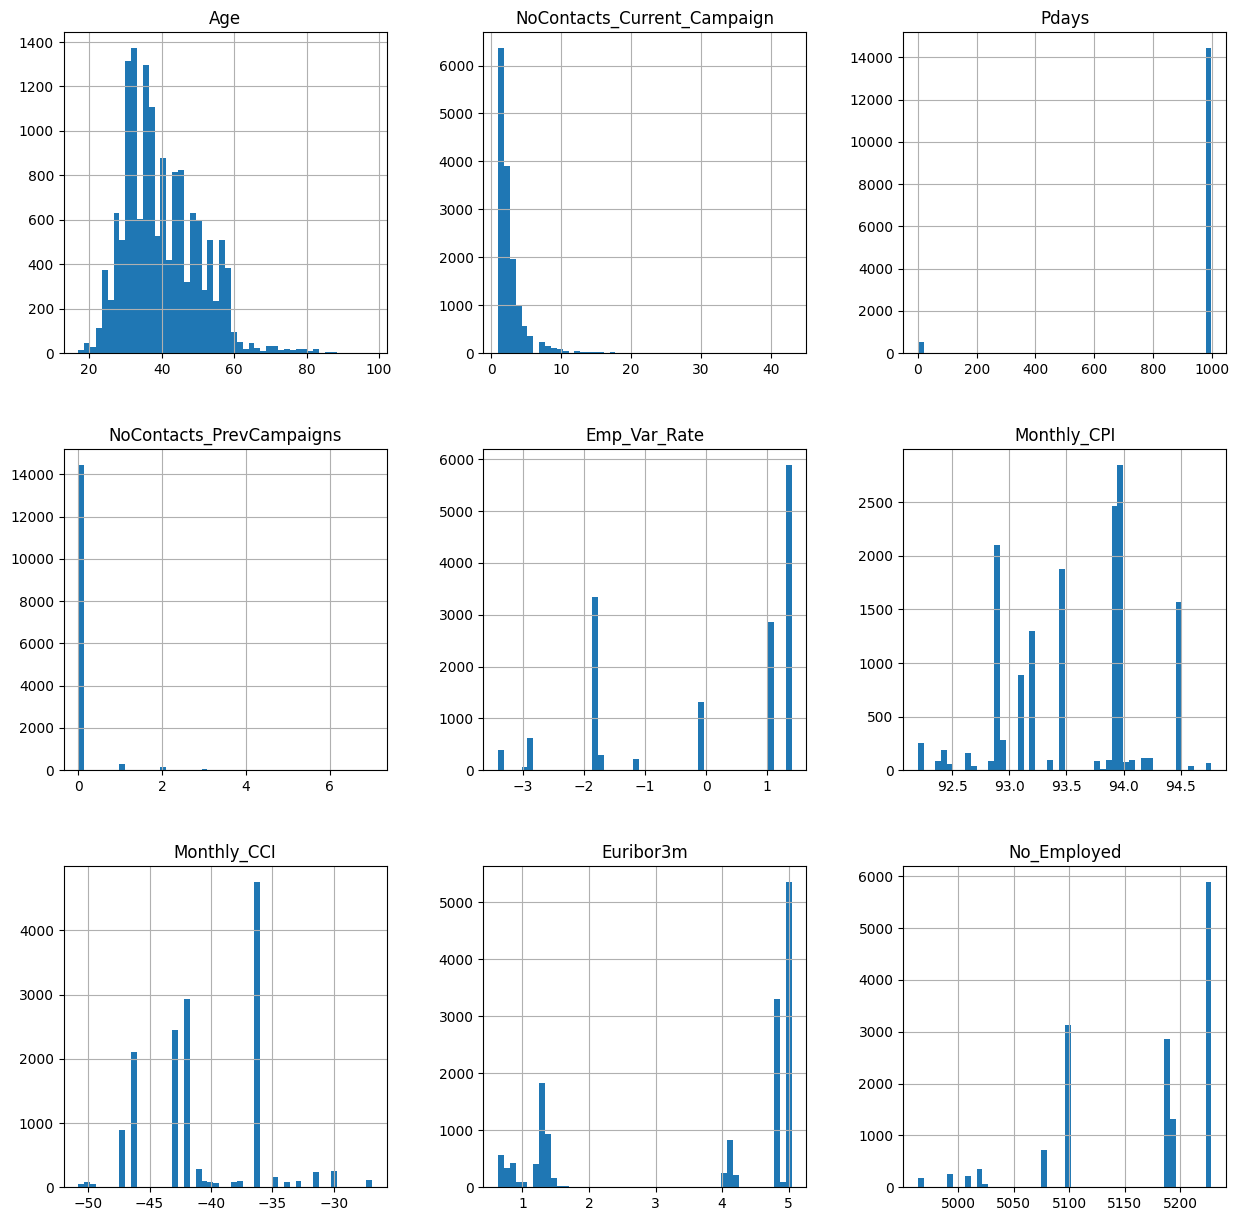

In [15]:
train_df[num_var].hist(bins=50, figsize=(15, 15))

Bar plots for categorical variables:

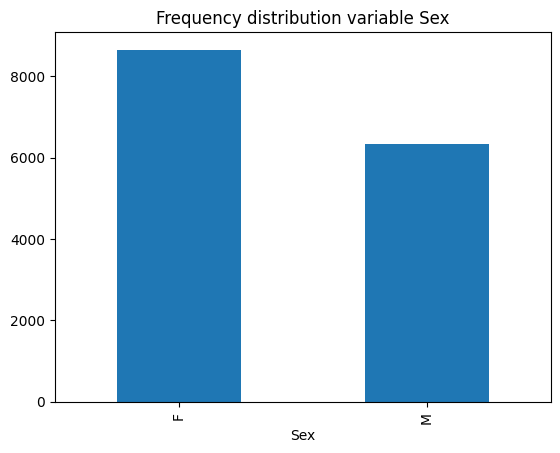

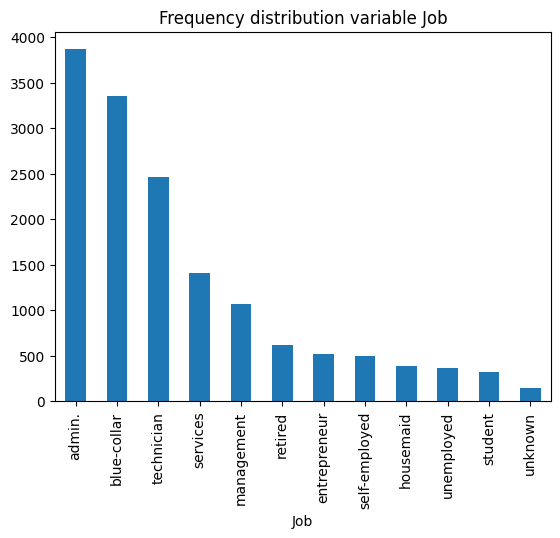

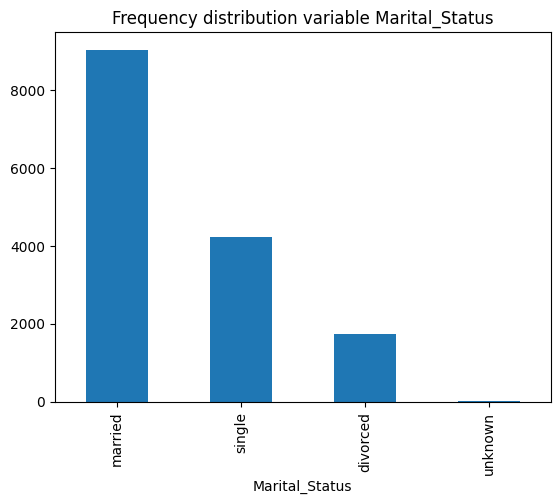

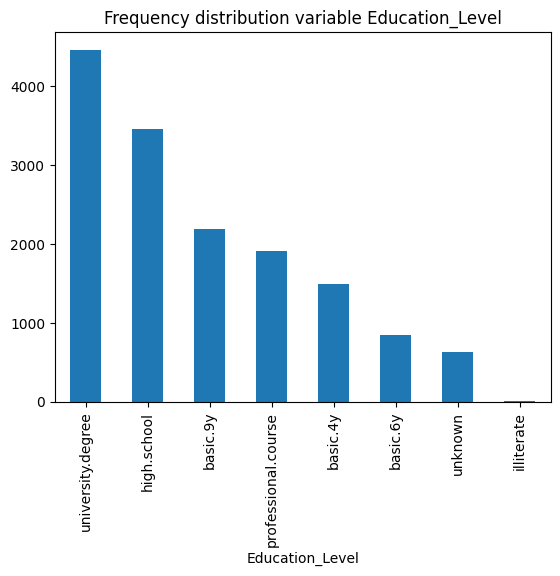

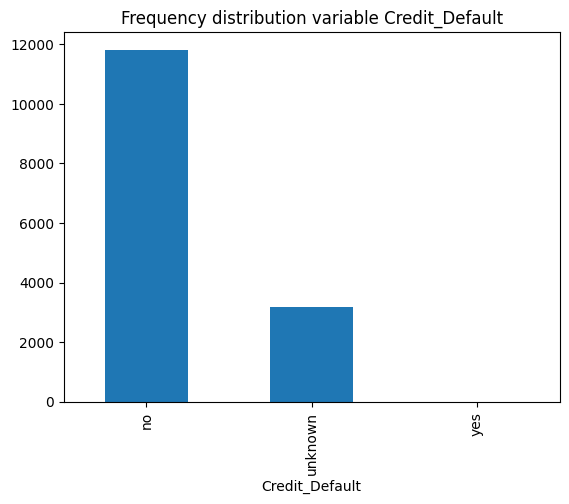

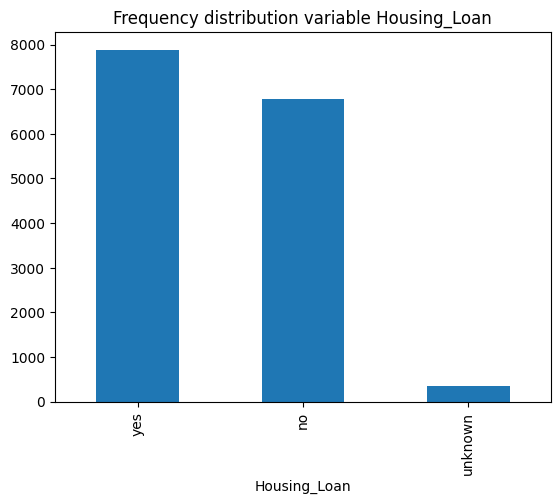

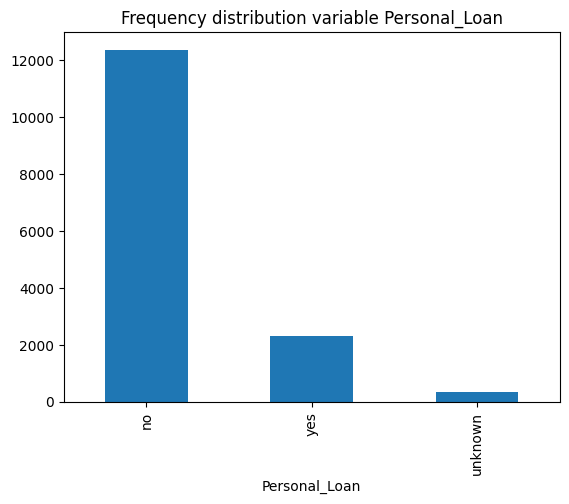

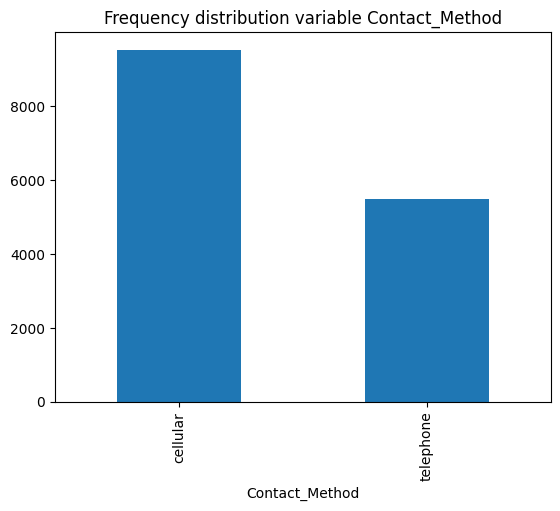

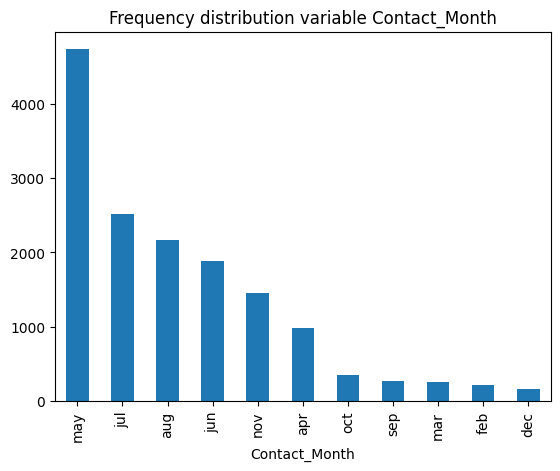

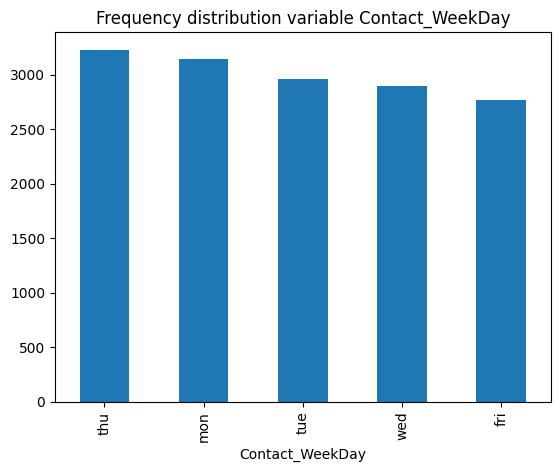

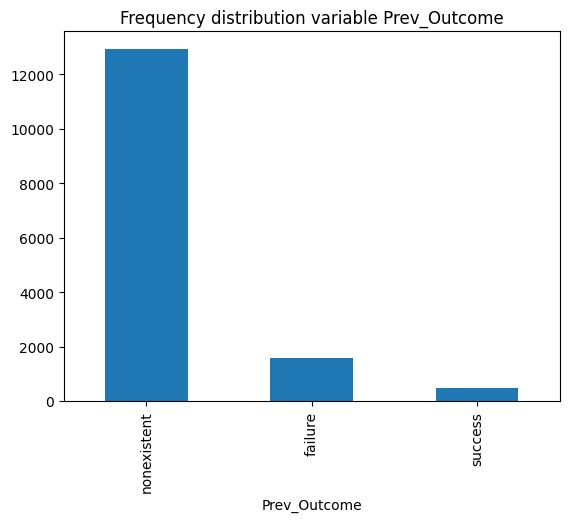

In [16]:
for var in cat_var:
    train_df[var].value_counts().plot(kind="bar", title=f"Frequency distribution variable {var}")
    plt.show()

### 1.4 Bivariate plots

Correlation between variables:

In [17]:
train_df[num_var].corr(method="pearson")

,Age,NoContacts_Current_Campaign,Pdays,NoContacts_PrevCampaigns,Emp_Var_Rate,Monthly_CPI,Monthly_CCI,Euribor3m,No_Employed
Age,1.000000,-0.008255,-0.051957,0.040046,-0.016034,-0.021054,0.106498,-0.010707,-0.026097
NoContacts_Current_Campaign,-0.008255,1.000000,0.035950,-0.033460,0.120269,0.102134,-0.001860,0.107207,0.111823
Pdays,-0.051957,0.035950,1.000000,-0.869459,0.267790,0.098362,-0.095617,0.285490,0.328452
NoContacts_PrevCampaigns,0.040046,-0.033460,-0.869459,1.000000,-0.230116,-0.063538,0.083312,-0.251812,-0.297465
Emp_Var_Rate,-0.016034,0.120269,0.267790,-0.230116,1.000000,0.772888,0.198656,0.972423,0.911972
Monthly_CPI,-0.021054,0.102134,0.098362,-0.063538,0.772888,1.000000,0.064184,0.690370,0.539850
Monthly_CCI,0.106498,-0.001860,-0.095617,0.083312,0.198656,0.064184,1.000000,0.276502,0.104239
Euribor3m,-0.010707,0.107207,0.285490,-0.251812,0.972423,0.690370,0.276502,1.000000,0.947667
No_Employed,-0.026097,0.111823,0.328452,-0.297465,0.911972,0.539850,0.104239,0.947667,1.000000


<ipython-input-18-0f4783709a0e>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("jet", 30)


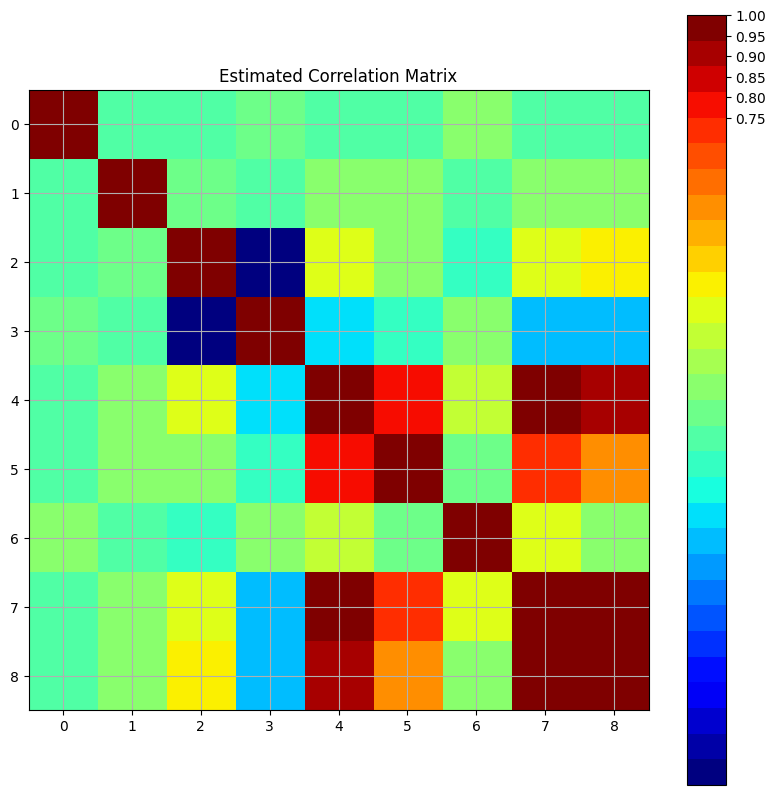

                  Name feature
0                          Age
1  NoContacts_Current_Campaign
2                        Pdays
3     NoContacts_PrevCampaigns
4                 Emp_Var_Rate
5                  Monthly_CPI
6                  Monthly_CCI
7                    Euribor3m
8                  No_Employed


In [18]:
def VizCorrelationMatrix(df):
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap("jet", 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title("Estimated Correlation Matrix")
    fig.colorbar(cax, ticks=[.75, .8, .85, .90, .95, 1])
    plt.show()
VizCorrelationMatrix(train_df[num_var])
print(pd.DataFrame(num_var, columns=["Name feature"]))

Plots of distribution of X|Y=1 and X|Y=0 for numerical variables:

Consider feature Age:


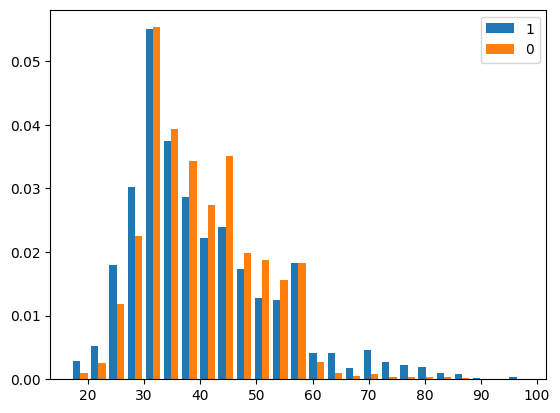

Consider feature NoContacts_Current_Campaign:


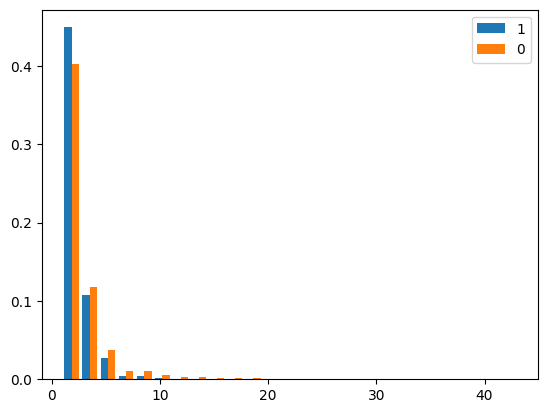

Consider feature Pdays:


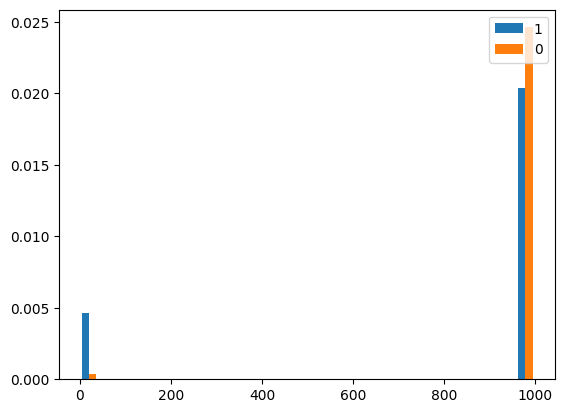

Consider feature NoContacts_PrevCampaigns:


In [ ]:
Z = train_df.copy()
for name in num_var:
    print("Consider feature " + name + ":")
    x = Z.where(Z["Outcome"]==1)[name]
    y = Z.where(Z["Outcome"]==0)[name]
    left =min(np.nanmin(x), np.nanmin(y))
    right =max(np.nanmax(x), np.nanmax(y))
    plt.hist([x, y], bins=25, range=[left, right], label=['1', '0'], density=True)
    plt.legend(loc="upper right")
    plt.show()

Via box plots:

In [ ]:
for var in num_var:
    train_df.boxplot(column=var, by="Outcome")

Empirical P(Y=1|X=x) for categorical  variables:

In [ ]:
for var in cat_var:
    train_df.groupby(var).agg({"Outcome": "mean"}).plot(kind="bar", title=f"Empirical P(Y=1|X=x) for variable {var}")

Elementary data analysis using pandas-profiling:

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train_df, title="Data report train set")
profile.to_notebook_iframe()

Questions:
*   Can you explain the observed patterns for Monthly_CPI, Monthly_CCI and Euribor3m?
*   What do you think of the data quality?
*   We have used the "train dataset" for the data analysis? Should we have included the "validation set" and "test set" as well? If not: should we carry out additional analyses?
*   Which variables do you consider promising for modelling?


## 2. Feature engineering

Build datasets with dummies for categorical variables:

In [ ]:
def add_dummies(df, cat_var):
    """Return new dataframe with dummy variables for specified categorical variables."""
    dummies_df = pd.DataFrame()
    for var in cat_var:
        aux = pd.get_dummies(df[[var]], prefix=f"ind_{var}", drop_first=False)
        dummies_df = pd.concat([dummies_df, aux], axis=1)
    return dummies_df

def build_X_y(df, num_var, cat_var, name_target):
    """Build datasets X, y for modelling."""
    num_df = df.copy()[num_var]
    dum_df = add_dummies(df, cat_var)
    X = pd.concat([num_df, dum_df], axis=1)
    y = df[name_target]
    return X, y

name_target = "Outcome"
X_train, y_train =  build_X_y(train_df, num_var, cat_var, name_target)
X_validation, y_validation =  build_X_y(validation_df, num_var, cat_var, name_target)
X_test, y_test =  build_X_y(test_df, num_var, cat_var, name_target)
# ensure common columns
cols = list(set(X_train.columns).intersection(set(X_validation.columns)).intersection(set(X_test.columns)))
X_train = X_train[cols]
X_validation = X_validation[cols]
X_test = X_test[cols]

### 2.1 Logit model

Available features:

In [ ]:
print(X_train.columns)

In [ ]:
selected_features = ["ind_Prev_Outcome_success", "ind_Contact_Method_telephone", "ind_Contact_Month_may"]

First we fit a logistic regression using the Scikit-learn package (for machine learning):

In [ ]:
logit = LogisticRegression(penalty="l2")

In [ ]:
logit.fit(X_train[selected_features], y_train)

Estimated coefficients:

In [ ]:
est_coef = pd.DataFrame(logit.coef_.T, index=selected_features, columns=["estimated coefficient"])
est_coef.loc["intercept", "estimated coefficient"] = logit.intercept_
display(est_coef)

The estimated probabilities Y=1:

In [ ]:
probs_train = logit.predict_proba(X_train[selected_features])[:, 1]
plt.hist(probs_train)

In [ ]:
threshold = 0.5
y_pred_train = (logit.predict_proba(X_train[selected_features])[:, 1] > threshold)

In [ ]:
def plot_confusion_matrix(hat_y, y, target_values):
    matrix = confusion_matrix(y, hat_y)  # note that true label corresponds to first argument
    sns.heatmap(matrix.T, square=True, annot=True, fmt="d", cbar=False,
    xticklabels=target_values, yticklabels=target_values)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    accuracy = accuracy_score(y, hat_y, normalize=True, sample_weight=None)
    print("The accuracy is " + str(np.round(100*accuracy,1)) + "%")

plot_confusion_matrix(y_pred_train , y_train, [0, 1])

In [ ]:
def plot_roc(y, hat_prob_y):
    RocCurveDisplay.from_predictions(
        y,
        hat_prob_y,
        name="ROC curve",
        color="darkorange",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve")
    plt.legend()
    plt.show()


plot_roc(y_train, probs_train)

**Question**: evaluate performance on validation set

#### Decision tree

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=40)
model_tree = clf.fit(X_train, y_train)
ax = plt.figure(figsize=(25, 25))
tree.plot_tree(model_tree, max_depth=3, filled=True, fontsize=10)

In [ ]:
hat_target_train_tree = model_tree.predict(X_train)

plot_confusion_matrix(hat_target_train_tree, y_train, [0, 1])
plot_roc(y_train,  model_tree.predict_proba(X_train)[:, 1] )

**Question:** evaluate performance on the validation set

Question:  investigate impact of the 'max_depth' parameter.

### Random forest

In [ ]:
clf = RandomForestClassifier(n_estimators=250, random_state=123)
rf = clf.fit(X_train, y_train)

In [ ]:
hat_target_train_rf = rf.predict(X_train)

plot_confusion_matrix(hat_target_train_rf, y_train, [0, 1])
plot_roc(y_train,  rf.predict_proba(X_train)[:, 1] )

**Question:** investigate performance on the validation set.

**Question:** Consider the documentation of Scikit and investigate impact of max_depth.

### Xgboost

In [ ]:
xgb = xgb.XGBClassifier()
xgb.fit(X_train, y_train)

In [ ]:
hat_target_train_xgb = xgb.predict(X_train)

plot_confusion_matrix(hat_target_train_xgb, y_train, [0, 1])
plot_roc(y_train, xgb.predict_proba(X_train)[:, 1] )

**Question**: determine performance on validation set

In [ ]:
hat_target_train_xgb = xgb.predict(X_validation)

plot_confusion_matrix(hat_target_train_xgb, y_validation, [0, 1])
plot_roc(y_validation, xgb.predict_proba(X_validation)[:, 1] )